## Klassifikation viraler Gene in zeitliche Expressionsphasen

In diesem Schritt werden alle verfügbaren RNA-Seq-Datensätze von Phagen analysiert, um jedem Gen ein zeitliches Expressions-Label zuzuweisen:  
**`early`**, **`middle`**, **`late`** oder **`unknown`**.

Die Klassifikation basiert auf den mittleren Expressionswerten über verschiedene Zeitpunkte hinweg.  
Je nach Anzahl verfügbarer Zeitpunkte wird unterschiedlich vorgegangen:

- **≥ 3 Zeitpunkte** → automatische Aufteilung in drei Phasen (jeweils ein Drittel): `early`, `middle`, `late`
- **2 Zeitpunkte** → Zuordnung zu `early` oder `late`
- **1 Zeitpunkt** → keine sinnvolle Klassifikation möglich → `unknown`

**Ziel:** Erstellung eines gelabelten Datensatzes zur weiteren Analyse, z. B. für maschinelles Lernen, Expressionsvergleiche oder Visualisierungen von Transkriptionsverläufen.

In [16]:
# === Bibliotheken einbinden ===
import pandas as pd
import os
import re

# === Funktion zur Gen-Klassifikation ===
def classify_expression_with_fallback(file_path):
    """
    Klassifiziert Gene basierend auf Expressionswerten zu unterschiedlichen Zeitpunkten
    in die Phasen: 'early', 'middle' oder 'late'.

    Die Zeitpunkte werden aus den Spaltennamen extrahiert und in Drittel unterteilt.
    """

    # Lese TSV-Datei ein (tabulatorgetrennt)
    df = pd.read_csv(file_path, sep='\t')

    # Erkenne und gruppiere Zeitspalten nach Zeitpunkten (z. B. "10_R1" → 10.0)
    timepoint_cols = {}
    for col in df.columns:
        match_r = re.match(r'^(\d+\.?\d*)_R\d+$', col)  # z. B. "10_R1"
        match_simple = re.match(r'^(\d+\.?\d*)$', col)  # z. B. "10"
        if match_r:
            time = float(match_r.group(1))
            timepoint_cols.setdefault(time, []).append(col)
        elif match_simple:
            time = float(match_simple.group(1))
            timepoint_cols.setdefault(time, []).append(col)

    # Sortiere Zeitpunkte
    sorted_times = sorted(timepoint_cols.keys())
    n = len(sorted_times)

    # Fall 1: keine Zeitpunkte erkannt
    if n == 0:
        raise ValueError("Keine gültigen Zeitpunkte gefunden.")

    # Fall 2: nur ein Zeitpunkt – Klassifikation nicht möglich
    elif n == 1:
        df['Label'] = 'unknown'

    # Fall 3: zwei Zeitpunkte – teile in 'early' und 'late'
    elif n == 2:
        early, late = sorted_times
        df['mean_early'] = df[timepoint_cols[early]].mean(axis=1)
        df['mean_late'] = df[timepoint_cols[late]].mean(axis=1)
        df['Label'] = df[['mean_early', 'mean_late']].idxmax(axis=1).str.replace('mean_', '')

    # Fall 4: drei oder mehr Zeitpunkte – unterteile in Drittel: early, middle, late
    else:
        early = sorted_times[:n // 3]
        middle = sorted_times[n // 3:2 * n // 3]
        late = sorted_times[2 * n // 3:]

        early_cols = [col for t in early for col in timepoint_cols[t]]
        middle_cols = [col for t in middle for col in timepoint_cols[t]]
        late_cols = [col for t in late for col in timepoint_cols[t]]

        df['mean_early'] = df[early_cols].mean(axis=1)
        df['mean_middle'] = df[middle_cols].mean(axis=1)
        df['mean_late'] = df[late_cols].mean(axis=1)

        # Bestimme die Phase mit der höchsten mittleren Expression
        df['Label'] = df[['mean_early', 'mean_middle', 'mean_late']].idxmax(axis=1).str.replace('mean_', '')

    # Rückgabe der wichtigsten Spalten mit Label
    return df[['Geneid', 'Entity', 'Symbol', 'Label']]

# === Verzeichnis mit den TSV-Dateien ===
data_folder = "../data/normalized_data/"
all_results = []

# === Schleife: Alle .tsv-Dateien im Verzeichnis verarbeiten ===
for file_name in os.listdir(data_folder):
    if file_name.endswith(".tsv"):
        file_path = os.path.join(data_folder, file_name)
        print(f"Verarbeite Datei: {file_name}")
        try:
            result = classify_expression_with_fallback(file_path)
            result['SourceFile'] = file_name  # Zurückverfolgbarkeit der Quelle
            all_results.append(result)
        except Exception as e:
            print(f"Fehler bei Datei {file_name}: {e}")

# === Ergebnisse zusammenführen und anzeigen ===
if all_results:
    final_df = pd.concat(all_results, ignore_index=True)
    display(final_df.head(10))  # Zeige erste 10 Ergebnisse

    # Übersicht 1: Verteilung der Labels gesamt
    print("\nAnzahl Gene je Label (gesamt):")
    print(final_df['Label'].value_counts())

    # Übersicht 2: Verteilung der Labels je Datei
    print("\nVerteilung je Datei:")
    label_counts_per_file = final_df.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)
    display(label_counts_per_file)

    # Optional: Ergebnisse als CSV speichern
    # final_df.to_csv("data/gene_labels_all_files.csv", index=False)
else:
    print("Keine gültigen Dateien verarbeitet.")

Verarbeite Datei: Brandao_LB_full_raw_counts_TPM.tsv
Verarbeite Datei: Ceyssens_non-directional_full_raw_counts_TPM.tsv
Verarbeite Datei: Guegler_T7_minusToxIN_full_raw_counts_TPM.tsv
Verarbeite Datei: Leskinen_full_raw_counts_TPM.tsv
Verarbeite Datei: Li_full_raw_counts_TPM.tsv
Verarbeite Datei: Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_TPM.tsv
Verarbeite Datei: Wolfram-Schauerte_full_raw_counts_TPM.tsv


,Geneid,Entity,Symbol,Label,SourceFile
0,gene-PA2589,host,gene-PA2589,middle,Brandao_LB_full_raw_counts_TPM.tsv
1,gene-PA1795,host,cysS,early,Brandao_LB_full_raw_counts_TPM.tsv
2,gene-PA2468,host,foxI,early,Brandao_LB_full_raw_counts_TPM.tsv
3,gene-PA4119,host,aph,middle,Brandao_LB_full_raw_counts_TPM.tsv
4,gene-PA2246,host,bkdR,middle,Brandao_LB_full_raw_counts_TPM.tsv
5,gene-PA1033,host,gene-PA1033,middle,Brandao_LB_full_raw_counts_TPM.tsv
6,gene-PA2214,host,gene-PA2214,middle,Brandao_LB_full_raw_counts_TPM.tsv
7,gene-PA3210,host,trkH,middle,Brandao_LB_full_raw_counts_TPM.tsv
8,gene-PA4724,host,gene-PA4724,middle,Brandao_LB_full_raw_counts_TPM.tsv
9,gene-PA5368,host,pstC,early,Brandao_LB_full_raw_counts_TPM.tsv



Anzahl Gene je Label (gesamt):
Label
early     19883
late       6503
middle     6379
Name: count, dtype: int64

Verteilung je Datei:


Label,early,late,middle
SourceFile,,,
Brandao_LB_full_raw_counts_TPM.tsv,2798,228,2693
Ceyssens_non-directional_full_raw_counts_TPM.tsv,5362,185,494
Guegler_T7_minusToxIN_full_raw_counts_TPM.tsv,3915,294,335
Leskinen_full_raw_counts_TPM.tsv,2485,1693,105
Li_full_raw_counts_TPM.tsv,1167,1746,835
Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_TPM.tsv,206,2086,1366
Wolfram-Schauerte_full_raw_counts_TPM.tsv,3950,271,551


## Klassifikation mit paper-spezifischen Zeitfenstern

In diesem Schritt erfolgt die Klassifikation der Gene nicht mathematisch, sondern basierend auf den biologisch oder experimentell festgelegten Zeitphasen aus den Originalpublikationen.

Für jedes Paper sind konkrete Zeitfenster definiert, die die Phasen **early**, **middle** und **late** beschreiben. Diese Zeitfenster werden genutzt, um Gene anhand ihrer mittleren Expressionsstärke in die entsprechende Phase einzuordnen.

**Ziel:** Eine biologisch fundierte Klassifikation zur besseren Vergleichbarkeit mit den Aussagen der Studien.


In [18]:
import pandas as pd
import os
import re

# === Zeitfenster pro Paper (in Minuten) ===
# Diese Werte stammen direkt aus den jeweiligen Publikationen
paper_time_windows = {
    "brandao": [(0, 5, "early"), (5, 10, "middle"), (10, 15, "late")],
    "ceyssens": [(0, 5, "early"), (5, 15, "middle"), (15, 35, "late")],
    "guegler": [(2.5, 5, "early"), (5, 10, "middle"), (10, 20, "late")],
    "leskinen": [(2, 5, "early"), (10, 21, "middle"), (28, 49, "late")],
    "li": [(0, 45, "early"), (45, 75, "middle"), (75, 135, "late")],
    "sprenger": [(0, 15, "early"), (15, 60, "middle"), (60, 120, "late")],
    "wolfram-schauerte": [(0, 5, "early"), (5, 10, "middle"), (10, 20, "late")]
}

# === Hauptfunktion zur Klassifikation mit biologisch definierten Zeiträumen ===
def classify_expression_paper_defined(file_path, paper_key):
    """
    Klassifiziert Gene in early/middle/late basierend auf
    paper-spezifischen Zeitfenstern (biologische Definition).
    """
    df = pd.read_csv(file_path, sep="\t")
    time_windows = paper_time_windows.get(paper_key)

    if time_windows is None:
        raise ValueError(f"Kein Zeitfenster für Paper '{paper_key}' definiert.")

    # Zeitspalten erkennen (z. B. "10_R1" oder "10")
    timepoint_cols = {}
    for col in df.columns:
        match_r = re.match(r'^(\d+\.?\d*)_R\d+$', col)
        match_simple = re.match(r'^(\d+\.?\d*)$', col)
        if match_r:
            time = float(match_r.group(1))
            timepoint_cols.setdefault(time, []).append(col)
        elif match_simple:
            time = float(match_simple.group(1))
            timepoint_cols.setdefault(time, []).append(col)

    # Zeitpunkte den biologisch definierten Phasen zuordnen
    window_columns = {"early": [], "middle": [], "late": []}
    for time, cols in timepoint_cols.items():
        for start, end, label in time_windows:
            if start <= time < end:
                window_columns[label].extend(cols)
                break

    # Mittelwert pro Phase berechnen (falls Spalten vorhanden)
    for label in ["early", "middle", "late"]:
        if window_columns[label]:
            df[f"mean_{label}"] = df[window_columns[label]].mean(axis=1)

    # Bestimme für jedes Gen die Phase mit der höchsten mittleren Expression
    df["Label"] = df[[f"mean_{l}" for l in window_columns if window_columns[l]]].idxmax(axis=1).str.replace("mean_", "")

    return df[['Geneid', 'Entity', 'Symbol', 'Label']]

# === Paper-Key automatisch aus dem Dateinamen ableiten ===
def infer_paper_key_from_filename(filename):
    """
    Ermittelt anhand des Dateinamens den passenden Paper-Schlüssel.
    """
    name = filename.lower()
    for key in paper_time_windows:
        if key in name:
            return key
    return None

# === Verzeichnis mit Daten ===
data_folder = "../data/normalized_data/"
all_results_paper_defined = []

# === Schleife: Alle Dateien verarbeiten ===
for file_name in os.listdir(data_folder):
    if file_name.endswith(".tsv"):
        paper_key = infer_paper_key_from_filename(file_name)
        if paper_key:
            file_path = os.path.join(data_folder, file_name)
            print(f"Verarbeite Datei: {file_name} ({paper_key})")
            try:
                result = classify_expression_paper_defined(file_path, paper_key)
                result['SourceFile'] = file_name  # für spätere Zuordnung
                all_results_paper_defined.append(result)
            except Exception as e:
                print(f"Fehler bei Datei {file_name}: {e}")
        else:
            print(f"Kein paper_key gefunden für Datei: {file_name}")

# === Ergebnisse zusammenführen & anzeigen ===
if all_results_paper_defined:
    final_df_paper_defined = pd.concat(all_results_paper_defined, ignore_index=True)
    display(final_df_paper_defined.head(10))

    print("\nAnzahl Gene je Label (gesamt):")
    print(final_df_paper_defined['Label'].value_counts())

    print("\nVerteilung je Datei:")
    display(final_df_paper_defined.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0))
else:
    print("Keine gültigen Dateien verarbeitet.")


Verarbeite Datei: Brandao_LB_full_raw_counts_TPM.tsv (brandao)
Verarbeite Datei: Ceyssens_non-directional_full_raw_counts_TPM.tsv (ceyssens)
Verarbeite Datei: Guegler_T7_minusToxIN_full_raw_counts_TPM.tsv (guegler)
Verarbeite Datei: Leskinen_full_raw_counts_TPM.tsv (leskinen)
Verarbeite Datei: Li_full_raw_counts_TPM.tsv (li)
Verarbeite Datei: Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_TPM.tsv (sprenger)
Verarbeite Datei: Wolfram-Schauerte_full_raw_counts_TPM.tsv (wolfram-schauerte)


,Geneid,Entity,Symbol,Label,SourceFile
0,gene-PA2589,host,gene-PA2589,middle,Brandao_LB_full_raw_counts_TPM.tsv
1,gene-PA1795,host,cysS,early,Brandao_LB_full_raw_counts_TPM.tsv
2,gene-PA2468,host,foxI,early,Brandao_LB_full_raw_counts_TPM.tsv
3,gene-PA4119,host,aph,middle,Brandao_LB_full_raw_counts_TPM.tsv
4,gene-PA2246,host,bkdR,middle,Brandao_LB_full_raw_counts_TPM.tsv
5,gene-PA1033,host,gene-PA1033,middle,Brandao_LB_full_raw_counts_TPM.tsv
6,gene-PA2214,host,gene-PA2214,middle,Brandao_LB_full_raw_counts_TPM.tsv
7,gene-PA3210,host,trkH,middle,Brandao_LB_full_raw_counts_TPM.tsv
8,gene-PA4724,host,gene-PA4724,middle,Brandao_LB_full_raw_counts_TPM.tsv
9,gene-PA5368,host,pstC,early,Brandao_LB_full_raw_counts_TPM.tsv



Anzahl Gene je Label (gesamt):
Label
early     19182
middle     8137
late       5446
Name: count, dtype: int64

Verteilung je Datei:


Label,early,late,middle
SourceFile,,,
Brandao_LB_full_raw_counts_TPM.tsv,2791,165,2763
Ceyssens_non-directional_full_raw_counts_TPM.tsv,5380,0,661
Guegler_T7_minusToxIN_full_raw_counts_TPM.tsv,2208,613,1723
Leskinen_full_raw_counts_TPM.tsv,2086,2018,179
Li_full_raw_counts_TPM.tsv,2009,958,781
Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_TPM.tsv,254,1692,1712
Wolfram-Schauerte_full_raw_counts_TPM.tsv,4454,0,318


## Vergleich der beiden Klassifikationsmethoden: Visualisierung & Auswertung

In diesem Abschnitt werden die Ergebnisse der beiden Ansätze zur zeitlichen Gen-Klassifikation gegenübergestellt:

1. **Standard-Methode**  
   → Gleichmäßige Aufteilung aller Zeitpunkte in drei Drittel: `early`, `middle`, `late`

2. **Paper-definierte Methode**  
   → Verwendung biologisch sinnvoller Zeitfenster auf Basis der Originalpublikationen

### Visualisierung

Für jede Datei wird dargestellt, wie viele Gene in die jeweiligen Phasen (`early`, `middle`, `late`) fallen.  
Dabei werden die Ergebnisse beider Methoden in separaten gestapelten Balkendiagrammen gegenübergestellt.  
Zur besseren Lesbarkeit der X-Achse werden die Dateinamen auf kurze Papernamen reduziert (z. B. `Li`, `Sprenger`).

### Vergleich der Label-Zuordnung

Anschließend wird geprüft, bei wie vielen Genen die beiden Methoden zu unterschiedlichen Ergebnissen führen.  
Die Auswertung zeigt:

- Wie viele Gene in beiden Methoden vorkommen
- Wie viele davon unterschiedlich gelabelt wurden
- Den prozentualen Anteil an abweichenden Labels

Dies hilft zu verstehen, welchen Einfluss die Wahl der Klassifikationsmethode auf die Genannotation hat.

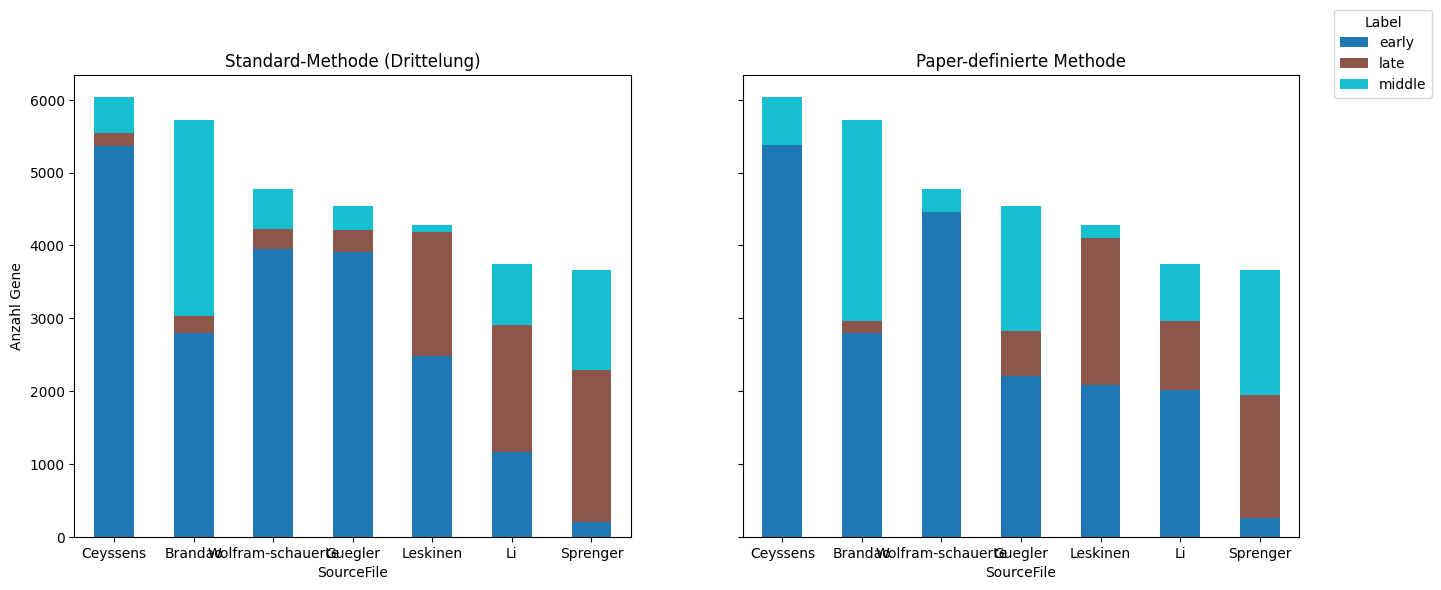

Gesamtzahl gemeinsam gelabelter Gene: 32765
Anzahl unterschiedlich gelabelter Gene: 5496
Anteil unterschiedlich gelabelter Gene: 16.77%
Anzahl gleich gelabelter Gene: 27269


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# === Hilfsfunktion: Dateinamen auf kurze Papernamen reduzieren ===
def extract_paper_short_name(filename):
    """
    Ermittelt anhand des Dateinamens den zugehörigen Paper-Kurznamen.
    """
    papers = [
        "brandao", "ceyssens", "guegler", "leskinen",
        "li", "sprenger", "wolfram-schauerte"
    ]
    filename_lower = filename.lower()
    for paper in papers:
        if paper in filename_lower:
            return paper.capitalize()  # z. B. "Li", "Sprenger"
    return filename  # Falls kein Match, gib Originalname zurück

# === Gruppiere Gene pro Label und Datei für beide Methoden ===
label_counts_std = final_df.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)
label_counts_paper = final_df_paper_defined.groupby(['SourceFile', 'Label']).size().unstack(fill_value=0)

# === Gemeinsame Sortierung der Dateien nach Anzahl gelabelter Gene ===
ordered_files = label_counts_std.sum(axis=1).sort_values(ascending=False).index
label_counts_std = label_counts_std.loc[ordered_files]
label_counts_paper = label_counts_paper.reindex(ordered_files).fillna(0)

# === Kürze die Dateinamen für X-Achse (z. B. „Li“, „Sprenger“) ===
short_labels = [extract_paper_short_name(f) for f in ordered_files]

# === Erstelle zwei nebeneinanderliegende Balkendiagramme ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Klassifikation mit Standard-Methode
label_counts_std.plot(
    kind='bar',
    stacked=True,
    colormap='tab10',
    ax=axes[0],
    legend=False
)
axes[0].set_title("Standard-Methode (Drittelung)")
axes[0].set_ylabel("Anzahl Gene")
axes[0].set_xticks(range(len(short_labels)))
axes[0].set_xticklabels(short_labels, rotation=0, fontsize=10)

# Plot 2: Klassifikation mit paper-definierter Methode
label_counts_paper.plot(
    kind='bar',
    stacked=True,
    colormap='tab10',
    ax=axes[1],
    legend=False
)
axes[1].set_title("Paper-definierte Methode")
axes[1].set_xticks(range(len(short_labels)))
axes[1].set_xticklabels(short_labels, rotation=0, fontsize=10)

# === Gemeinsame Legende außerhalb der Diagramme platzieren ===
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Label", bbox_to_anchor=(1.02, 1), loc='upper left')

# === Layout optimieren ===
plt.subplots_adjust(right=1)
plt.show()

# === Vergleiche Klassifikationsergebnisse beider Methoden auf Gen-Ebene ===

# Füge die beiden DataFrames zusammen – nur dort, wo Gene in beiden vorkommen
merged = final_df.merge(
    final_df_paper_defined,
    on=['Geneid', 'Entity', 'Symbol', 'SourceFile'],
    suffixes=('_std', '_paper')  # Label-Spalten: Label_std, Label_paper
)

# === Finde Gene, deren Klassifikation sich zwischen den beiden Methoden unterscheidet ===
differences = merged[merged['Label_std'] != merged['Label_paper']]

# === Statistische Auswertung ===
total = len(merged)              # Gesamtzahl der gemeinsam gelabelten Gene
diff_count = len(differences)    # Anzahl abweichender Klassifikationen
same_count = total - diff_count  # Anzahl übereinstimmender Klassifikationen
percentage_diff = round((diff_count / total) * 100, 2)  # Prozentuale Abweichung

# === Ausgabe der Ergebnisse ===
print(f"Gesamtzahl gemeinsam gelabelter Gene: {total}")
print(f"Anzahl unterschiedlich gelabelter Gene: {diff_count}")
print(f"Anteil unterschiedlich gelabelter Gene: {percentage_diff}%")
print(f"Anzahl gleich gelabelter Gene: {same_count}")

